# Machine Learning / Space Image Processing - Final Project

#### George Choumos - <span style="color:red">Space Technologies, Applications & Services</span>

### Prerequisites & Assumptions
For this notebook run we consider that we have:
* An `images` folder in the current directory
* The `images` folder contains 30 image files
  * 10 taken during fall
  * 10 taken during winter
  * 10 taken during spring
* All of the image files are under the convention that they start with the first capital letter of the season they were taken on, followed by the number of that picture. So we have:
  * `F1.jpg, F2.jpg, ..., F10.jpg` \- for Fall images
  * `W1.jpg, W2.jpg, ..., W10.jpg` \- for Winter images
  * `S1.jpg, S2.jpg, ..., S10.jpg` \- for Spring images


### Python Libraries used
The libraries we use are the following:
* **`cv2`** to read and manipulate the images
* **`matplotlib`** for the plot generation
* **`numpy`** to handle our input data as numpy arrays
* **`sys`** for helper functions
* **`pdb`** for debugging purposes
* various modules from **`sklearn`** for the machine learning parts of the project
  * `PCA` - Principal Component Analysis
  * `KNeighborsClassifier` - k-Nearest Neighbors
  * `LinearSVC` - Linear Support Vector Classifier
  * `cross_val_score` - For the cross validation
  * `ShuffleSplit` - To enable shuffling of the inputs and labels and obtain a cross validation iterator

In [1]:
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
import matplotlib.offsetbox as ofb
import matplotlib.image as img
import cv2
import sys
import pdb

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, ShuffleSplit

%matplotlib inline

## 1.1 - Image load and resize - Label mappings
For the purpose of this question, we define the `loadImages` function. It receives the path where the original input images are and does the following:
* Reads the color images.
  * The **default** behaviour is to maintain the color information, thus read 3 values per pixel.
  * It can be configured to read in grayscale which is going to be useful for a comparison we'll do later on. In this case, it will generate only 1 value per pixel instead.
* Resizes each image so that their shape becomes 100*100 pixels
* Returns all 30 resized images in a 30-column array. Each column is actually a vector that represents the resized image.
* Also returns the image labels as integers so that:
  * 0 - represents images that were taken during fall
  * 1 - represents images that were taken during winter
  * 2 - represents images that were taken during spring

In [2]:
"""
  The loadImages function:
  * Reads the images in the following order:
        F1, F2, ..., F10, W1, W2, ..., W10, S1, S2, ..., S10
  ** maintaining color information by default
  ** in grayscale if color argument is passed as False
  * Resizes them so that they become 100*100 pixels
  * Reshapes the images so that they change from shape (30,100,100) to (30,10000)
  * Returns their labels
"""
def loadImages(path, color=True):
    images = []
    for c in ['F', 'W', 'S']:
        for n in range(1,11):
            images.append(
                cv2.resize(
                    cv2.imread('{0}/{1}{2}.jpg'.format(path,c,n),1 if color else 0),(100,100)))
    images = np.array(images).reshape(30,100*100*3 if color else 100*100)
    # The labels are just 10 zeroes, 10 ones and 10 twos
    # corresponding to the order we read the images
    labels = 10*[0] + 10*[1] + 10*[2]
    return images, labels

Load the images and the labels:

In [3]:
images, labels = loadImages('./images')

## 1.2 - Running the PCA and using the transformed data for image visualisation
Define the `PCA_ImageSpaceVisualization` function that will:
* Receive the image array as input
* Calculate the 2 principal components of the images
* Plot the images on those 2 principal components

Given we have jpg images that we want to plot, we have also installed **Pillow**. Matplotlib only supports png images natively. Another way could be to convert those jpg images to png and then just use matplotlib.

Note that there is no need to apply scaling before PCA as all our features represent the same thing and are expressed in the same units, ie. a pixel value with the same range for all. This is supported by the _"Introduction to Statistical Learning with Applications in R"_ book. In fact, even if scaling is applied (which I tried out of curiosity) there is no visible change in the results. I didn't include this experimentation here, so you have to take my word for it!

In [4]:
def PCA_ImageSpaceVisualization(images, color=True):
    pca = PCA(n_components=2)
    pca.fit(images)
    images_pca = pca.transform(images)
    fig, ax = plt.subplots()
    title = "Season images {0} colour information".format("with" if color else "without")
    plt.title(title + "\nPlotted based on their first 2 principal components.\n")
    # Get the minimum and maximum of each of the 2 principal components
    # to derive the range of each axis 
    ax.set_xlim(images_pca[:,0].min()-1050, images_pca[:,0].max()+1050)
    ax.set_ylim(images_pca[:,1].min()-1050, images_pca[:,1].max()+1500)

    # Print out some more information around pca
    print('Amount of variance explained:')
    print('  1st component: {0:.3f}%'.format(pca.explained_variance_ratio_[0]*100))
    print('  2nd component: {0:.3f}%'.format(pca.explained_variance_ratio_[1]*100))

    # Read the 30 images in the order that they were read and they appear in the pca resulting values
    loop = 0
    for season in ['F','W','S']:
        for i in range(1,11):
            ax.add_artist(
                ofb.AnnotationBbox(
                    ofb.OffsetImage(
                        img.imread('./images/{0}{1}.jpg'.format(season,i)),
                        zoom=0.3
                    ),
                    (images_pca[loop*10+i-1][0],images_pca[loop*10+i-1][1])
                )
            )
        loop += 1
    plt.show()

Amount of variance explained:
  1st component: 46.444%
  2nd component: 9.279%


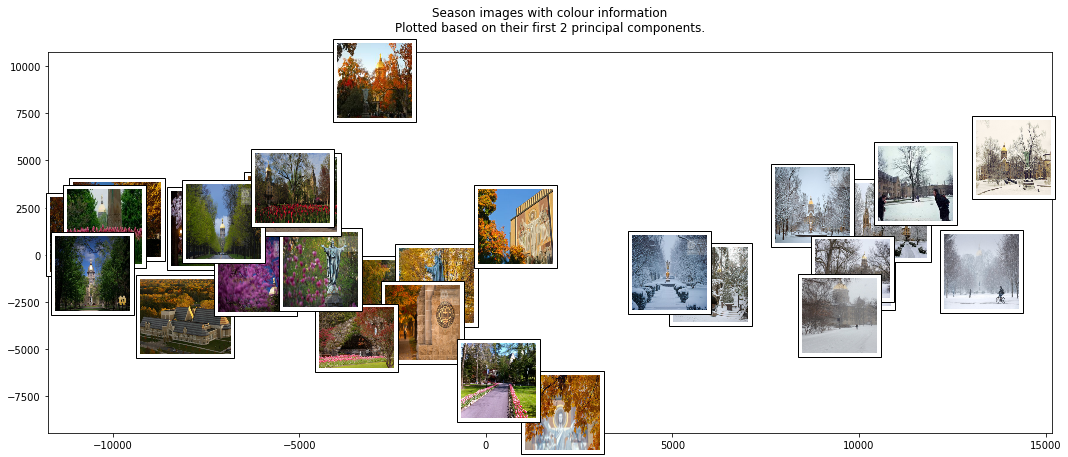

In [5]:
# Applying this here because it seems that there is a known bug which
# prevents the memory of rcParams to be kept between cells.
# For more: https://github.com/ipython/ipython/issues/11098
plt.rcParams["figure.figsize"] = (18,7)

PCA_ImageSpaceVisualization(images)

### 1.2.1/1.2.2 - Comments on plot resulting from PCA

#### General
We are using principal components analysis here to derive a 2-dimensional set of features. **Principal Components Analysis** is an unsupervised technique for reducing the dimensionality of a $nxP$ data matrix $\mathbf{X}$. It is often used for data visualisation or as a data preprocessing tool before supervised techniques are applied. It can find a low-dimensional representation of the data that captures as much of the information as possible.

The first principal component is the direction along which there is the greatest variability in the data. It can be also interpreted as the line that is as close as possible to the data. Then the second is the direction along which there is the 2nd greatest variability in the data after the 1st.

#### Closeness of observations in plot after PCA
After PCA is applied, we plotted the images (instead of points) on the 2-dimensional space that occured after the calculation of the first 2 principal components. What we know from theory for PCA, is that points that appear to be close after it is applied, are points that share similar characteristics.

In our case, in the plot that was generated, we can see that there is a tendency for images of the same season to appear closer together than images of different seasons. So the season and how it is reflected in the pixel values (eg. the dominant colours for each season) on the high level could be the underlying characteristic that is similar for those images.

We can also see that the main axis on which the seasonal differences appear is the X axis which corresponds to the first principal component. There is no evident correlation that really stands out from the perspective of our visual interpretation between the values of the Y-axis, ie. the second principal component and the season that the photo was captured in.

In fact, this should not be surprising after checking the amount of variance that is explained per principal component. The first principal component explains **46.44%** of the variance in the input data, while the second principal component accounts for only **9.28%**. We will talk a bit more about this later on.

So, returning to the closeness of observations and how it can be interpreted:
* the closer the images appear to be, the more likely they are to have been taken during the same season, while
* the farther they appear, the more likely they are to have been taken during a different season
* the distance is particularly important for the x-axis that corresponds to the first principal component. On the other hand, this doesn't seem to be the case, at least not as much for the y-axis that corresponds to the second principal component.

#### Generalizing for the high-dimensional space
So we used PCA and transformed our datapoints/images, reducing their dimensionality from 100x100 down to only 2 dimensions, ie. the first 2 principal components. This, enabled us to plot them in the 2-dimensional space, which we are familiar with and then, in turn, it enabled us to identify the distances between them. We are so familiar with this 2-dimensional representation which makes it easy to understand that there is an evident grouping of the images and that they tend be closer if they belong to the same season.

However, generalising this euclidean-distance-related closeness to the high-dimensionality of the original data is not  something we should do. Most of the algorithms that work well in 2-dimensions, or, more generally, in a low dimensionality setting, are troublesome with high-dimensional inputs.

The notion of distance, either it is euclidean, or manhattan or some other common distance metric, works well in the low-dimensional setting but, when it comes to high-dimensional settings, they have some properties which are not aligned with our intuition.

High dimensional problems suffer from what is known as the ***Curse of Dimensionality***. As the dimensionality increases, the volume of space increases so fast that the available inputs become sparse. There is a well known analogy for the high-dimensionality problem. As it is described in "*A Few Useful Things to Know About Machine Learning*", in high dimensions, most of the mass of a multivariate Gaussian distribution is not near the mean, but in an increasingly distant "shell" around it. Or, as a common analogy goes, most of the volume of a high-dimensional orange is in the skin and not in the pulp. If a constant number of examples is distributed uniformly in a high-dimensional hypercube, beyond some dimensionality, most examples are closer to a face of a hypercube than to their nearest neighbor. And if we approximate a hypersphere by inscribing it in a hypercube, in high dimensions almost all the volume of the hypercube is outside the hypersphere. Given we approximate shapes of one type (hyperspheres) with shapes of another (hypercubes), this is really bad news.

So, simply put, there are no points that are close-enough to be considered neighbours in the high dimensions! So, generalizing our case for the high-dimensional setting is not a valid thing to do light-heartedly.

#### On the images for a specific season appearing closer compared to the rest
Looking at the plot that was generated after applying PCA and examining the position of the images, we notice that the ones for Winter in particular, seem to be better separated from the rest. For Spring and Fall, while we do see separation there as well for the most part, the images from those 2 seasons are quite close neighbors compared to winter. We could say that we see some neighborhood overlap, as well as some cases where fall images belong well inside the spring area and the other way around.

So what could the reason be for this? Can the principal components (at least the first one) be interpreted as an intuitive characteristic of the images? Our first guess could potentially be that it corresponds to some colour-related attribute, as we have 10-thousand values per colour (R/G/B) per image. As far as colours are concerned we could say that:
* Winter images have white as the dominant colour
* Fall images have an orange-ish colour as the main one
* Spring images are mostly dominated by green as well as some other vivid colours because of the vegetation.

However, we can't really fully justify the above based on colour only, as we already mentioned that some orange-ish photos appear well inside the spring group of images and the other way around. So, is colour that important?

Let's do a small experiment, by repeating the PCA and plotting on images that are read in grayscale:

Amount of variance explained:
  1st component: 50.174%
  2nd component: 9.458%


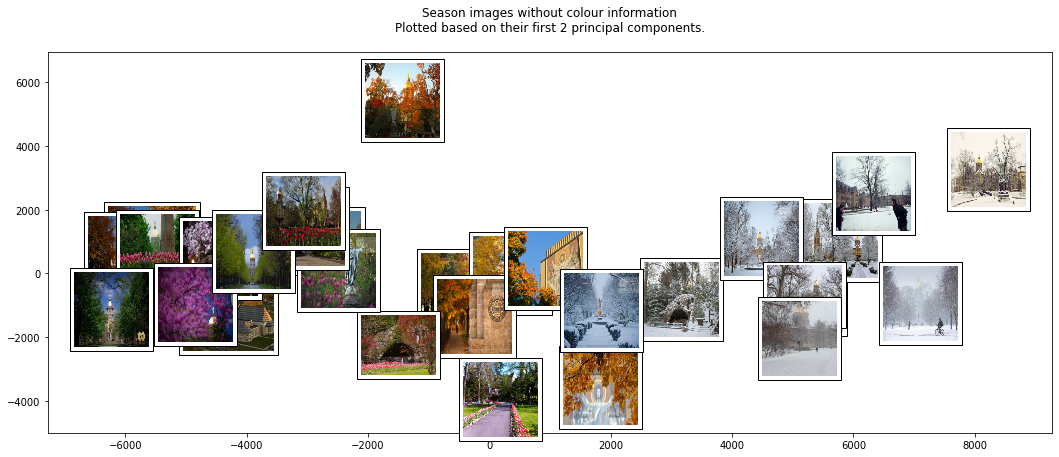

In [6]:
# Applying this here because it seems that there is a known bug which
# prevents the memory of rcParams to be kept between cells.
# For more: https://github.com/ipython/ipython/issues/11098
plt.rcParams["figure.figsize"] = (18,7)

images_grayscale, labels = loadImages('./images',color=False)
PCA_ImageSpaceVisualization(images_grayscale,color=False)

What is interesting to note for the above, is that it is quite similar to the plot that was generated after PCA was applied to the inputs that retained the colour information. So it seems that it's not the colour values as they are, but another characteristic that is really driving the results here.

Talking about grayscale and about what information we can get from it, we can quickly reach to a specific characteristic, that is **brightness**. To be able to easily understand this we can start from the winter photos.

There is a feature that stands out for the winter photos and, in fact, there is an interpretation for it that originates from a common measurement of surfaces that is being examined especially in the science of Remote Sensing.

That measurement is called **_Albedo_**, and it relates to how much light that hits a surface is reflected without being absorbed. Something that appears white reflects most of the light that hits it, and it is said to have high albedo. On the other hand, something that appears dark, absorbs much of the light that hits it and it is said to have low albedo.

Now, for our case and the images that we are using, we can easily see that in all winter photos, snow is the dominant element. To add to this, it's not only snow that dominates, but as a second dominant element in most of the winter photos we can see that the sky in the background also appears white, a whiteness originating by clouds. And actually, both snow and clouds are well known for their high albedo.

The result of a photo with high-albedo elements is that it will tend to appear white, and this in turn means that the pixel values are going to be close to the white values, ie. the maximum values.

Now, the high albedo that characterizes the elements of winter photos is not something that, even in the slightest, matches what the case is for the rest of the seasons. And taking into account the fact that we have now read the images in grayscale means that:
* Winter photos with snow and, thus, high albedo are going to display an evident shift to the right when plotted after applying PCA, because in grayscale they are sufficiently whiter and brighter than the photos of the other seasons. So they appear well separated (and clustered) compared to the rest.
* For the other two seasons, though the photos differ enough to display an evident separation, there is some overlap in the "perceived" boundary, as not all of them are different enough on their first principal component, which is likely closely related to brightness.

There is some more justification to the spring and fall photos displaying some overlap and it is once again relevant to the techniques and elements used in the science of Remote Sensing. Although there is an obvious differentiation between winter and the rest, which is mainly attributed to the existence of snow, for the other 2 seasons, the changes are mainly related to the healthiness of the vegetation. We know that the vegetation is generally more healthy in spring compared to fall.
* A healthy leaf produces significant amounts of chlorophyl and is better hydrated. Both these factors contribute to it displaying lower albedo.
* A stressed leaf, produces less chrolophyl and that may be because it reaches the end of its life (in fall) or because of not enough water or because of an underlying condition. This results in it absorbing less light and displaying a higher albedo. This is why it can be easily noted that the pictures taken in fall appear brighter than the ones taken in spring.
* However, the amount of this brightness and how much a specific image differs between spring and fall is also a function of what amount of vegetation is captured in a picture. If most part of a picture captures other things that don't change (like for example a landmark) then the differences between these 2 seasons will be less evident so they may appear quite close in the 2-dimensional plot.

So to make the long story short, there is a difference in brightness between winter, fall and spring that relates to the albedo and originates from
* the existence of snow
* the amount of vegetation
* the vegetation health

and this difference in brightness is directly affecting the pixel values and the closeness of the photos in our plot.

### 3. Classification Accuracy - k-NN, SVM and classification results comparison

#### Classification Accuracy
Suppose that we want to estimate $f$ on the basis of training observations ${(x_1,y_1),...,(x_n,y_n)}$, where $y_1,...,y_n$ are qualitative. In our case they are 0, 1 and 2 that correspond to Fall, Winter and Spring. Even though they are numbers, they are qualitative and not quantitative because they are used only to encode the seasons and because there is no ordering that makes sense in the seasons in a similar way to the natural ordering of the numbers.

#### Classification Accuracy - Simple Mathematical Definition
The definition for classification accuracy is the proportion of the correct predictions of our classifier. So it is defined as
\begin{equation}
\text{Classification Accuracy}= \frac{\text{number of correct class predictions}}{\text{total number of class predictions}}
\end{equation}

If we want to take it one step further we could further specify classification accuracy for our problem by defining:
* $TS$ - The "True Springs" - Cases that were correctly classified as Spring
* $FS$ - The "False Springs" - Cases that were mistakenly classified as Spring
* $TF$ - The "True Falls" - Cases that were correctly classified as Fall
* $FF$ - The "False Falls" - Cases that were mistakenly classified as Fall
* $TW$ - The "True Winters" - Cases that were correctly classfied as Winter
* $FW$ - The "False Winters" - Cases that were mistakenly classified as Winter

Which would lead to a classification accuracy expressed as:
\begin{equation}
\text{Classification Accuracy}= \frac{TS+TF+TW}{TS+TF+TW+FS+FF+FW}
\end{equation}

#### Quantifying the Classification Accuracy
There are 2 common approaches to quantify the accuracy of the classifier:
* The training error rate
* The test error rate

##### Training error rate
The training error rate quantifies the accuracy of the estimate $\hat{f}$ by calculating the proportion of mistakes that are made if we apply our estimate $\hat{f}$ to the training observations:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n} I(y_i\neq\hat{y_i})
\label{eq:classification error train} \tag{1}
\end{equation}
In the above
* $\hat{y_i}$ is the predicted class label for the $i$th observation using $\hat{f}$
* $I(y_i\neq\hat{y_i})$ is an indicator variable that equals 1 if $y_i\neq\hat{y_i}$ and 0 if $y_i=\hat{y_i}$

If $I(y_i\neq\hat{y_i})=0$, then the $i$th observation was classified correctly by our classification method, otherwise it was misclassified.

When computed based on the data that were used to train our classifier, equation $\eqref{eq:classification error train}$, is referred to as the _training error_ rate. It computes the fraction of incorrect classifications on training data.

##### Test error rate
The _test error_ rate associated with a set of test observations of the form $(x_0,y_0)$ is given by
\begin{equation}
Ave(I(y_0\neq\hat{y_0}))
\label{eq:classification error test} \tag{2}
\end{equation}
where $\hat{y_0}$ is the predicted class label that results from applying the classifier to the test observation with predictor $x_0$.

A good classifier is one for which the test error $\eqref{eq:classification error test}$ is the smallest.

#### Some info on $k$-Nearest Neighbors
$k$-Nearest Neighors, usually abbreviated as k-NN, is a classification method that attempts to estimate the conditional distribution of $Y$, given $X$, and then classify a given observation to the class with the highest estimated probability. What it does is that given:
* a positive integer $K$ and
* a test observation $x_0$,
the k-NN classifier first identifies the K points in the training data that are closest to $x_0$, represented by $\mathcal{N}_0$

It then estimates the conditional probability for class $j$ as the fraction of points in $\mathcal{N}_0$ whose response values equal $j$:
\begin{equation}
Pr(Y=j|X=x_0)=\frac{1}{K}\sum_{i\in\mathcal{N}_0}I(y_i=j)
\label{eq:knn} \tag{3}
\end{equation}

Finally, k-NN applies Bayes rule and classifies the test observation $x_0$ to the class with the largest probability.

#### Some info on Support Vector Machines
Although in our case we are testing a linear Support Vector Machine (SVM), in fact, Support Vector Machines are considered an extension of the Support Vector Classifiers in the sense that they can also accommodate non-linear kernels. The idea is that instead of just fitting a separating line/plane/hyperplane, SVMs also try to maximize the margin so that it is as far as possible from the training observations.

When a separating line/plane/hyperplane exists, then there exist infinite such hyperplanes, so considering which provides the maximal margin is a good way to choose among them. However, a separating line/hyperplane doesn’t always exist (unless we increase the dimensionality which is not always a good idea).

What happens when it doesn’t exist though? Well, this support vector classifier is also called a __*soft margin classifier*__.
* The margin is “soft” because it can be violated by some of the observations.
* An observation can be not only on the wrong side of the margin, but also on the wrong side of the hyperplane.
* The “Support Vector” part of its name comes from the few observations that are equidistant from the maximal margin line/hyperplane. These observations are known as __*support vectors*__ as they support the hyperplane and changing them even slightly, will also move the hyperplane.

The support vector classifier assigns an observation to a class depending on which side of the hyperplane it is, in our case, on which side of the line. It is the solution to the following optimization problem:

\begin{equation}
\underset{\beta_0,\beta_1,...,\beta_p,\epsilon_1,...,\epsilon_n,M}{maximize}M,
\label{eq:svc1} \tag{4}
\end{equation}

subject to the following
\begin{equation}
\sum_{j=1}^{p} \beta_j^2=1,
\label{eq:svc2} \tag{5}
\end{equation}

\begin{equation}
y_i(\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_px_{ip}) \geq M(1-\epsilon_i),
\label{eq:svc3} \tag{6}
\end{equation}

\begin{equation}
\epsilon_i \geq 0, \sum_{i=1}^{n} \epsilon_i \leq C,
\label{eq:svc4} \tag{7}
\end{equation}

where $C$ is a nonnegative tuning parameter and $M$ the width of the margin which we want to make as large as possible.

##### Multi-class Classification with SVMs
In order to extend SVMs to tackle multi-class problems, there are 2 approaches that are very popular:
* **One-VS-One** approach where ${K \choose 2}$ SMVs are constructed, each of which compares a pair of classes ($K$ is the number of classes). A test observation is classified using each of the ${K \choose 2}$ classifiers and we take into consideration the number of times that the test observation is assigned to each of the $K$ classes. In the end, we eventually assign the test observation to the class in which it was most frequently assigned after the ${K \choose 2}$ pairwise classifications.
* **One-VS-Rest** approach (or One-VS-All) is a bit different in the sense that $K$ SVMs are fit, each of which compares one of the $K$ classes to the remaining $K-1$ classes. In the end, the test observation is assigned to the class for which the probability to be a member of is the highest of all the others.

### Comparing the $k$-NN and Linear SVM classifiers

We are going to:
* Define the **1-NN** Classifier
* Define the **Linear SVM** (Linear SVC) Classifier
* Run a 5-fold cross validation for both classifiers against the initial high-dimensional data
* Run a 5-fold cross validation for both classifiers against low dimensional data extracted by applying PCA to the initial data
* Create a scree plot to understand the impact of the number of principal components and justify the final selection of the number of components.

#### 1-NN classifier - Definition

In [7]:
one_nn = KNeighborsClassifier(n_neighbors=1)

#### Linear SVM - Definition

In [8]:
linear_svc = LinearSVC(tol=1e-5)

#### Cross validation iterator creation through shuffling of the input data
As we read the input data in order, let's create a shuffled cross validation iterator now, which will enable us to produce folds that will be more meaningful:

In [9]:
cv_shuf = ShuffleSplit(n_splits=5, test_size=0.2, random_state=100)

#### High Dimensional Data - 1-NN and Linear SVC
Run the 5-fold cross validation and report the scores per fold and their mean. Note that in the `cv` argument we provide the cross validation iterator we just created.

In [10]:
scores_1nn_high = cross_val_score(one_nn,images,labels,cv=cv_shuf)
print("Scores for each of the 5 folds: {0}".format(scores_1nn_high))
print("Mean: {0:.3f}".format(np.array(scores_1nn_high).mean()))

Scores for each of the 5 folds: [0.66666667 1.         0.66666667 0.83333333 0.83333333]
Mean: 0.800


In [11]:
scores_lin_svc_high = cross_val_score(linear_svc,images,labels,cv=cv_shuf)
print("Scores for each of the 5 folds: {0}".format(scores_lin_svc_high))
print("Mean: {0:.3f}".format(np.array(scores_lin_svc_high).mean()))

/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scores for each of the 5 folds: [0.66666667 1.         0.5        0.66666667 1.        ]
Mean: 0.767


##### A comment on the mean accuracy
A thing that is worth noting here about the mean accuracy is that `random_state` is affecting the score a lot as you can get values of mean accuracy from 0.6 to 0.867 depending on its value. This is normal though as we only have a total of 30 datapoints and, given we are doing 5 folds, we only have 6 items each time in the test set.

#### Low Dimensional Data - Deciding on the number of principal components
There is a double-sided question that occurs when we extract principal components from a dataset, and that is:
* How much of the information in the dataset is lost by projecting the observations onto the principal components?
* How much of the variance in the data is not contained in the first few principal components?

A common metric that accompanies the principal components analysis is known as the ***proportion of variance explained*** by each of the principal components.

Assuming that the variables have been centered to have mean zero, the total variance present in a data set is defined as:
\begin{equation}
\sum_{j=1}^{p} Var(X_j)=\sum_{j=1}^{p}\frac{1}{n}\sum_{i=1}^{n}x_{ij}^2 .
\label{eq:total variance in dataset} \tag{8}
\end{equation}

The variance explained by the $m$th principal component is
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}\mathcal{z}_{im}^2=\frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{p}\phi_{jm}x_{ij}\right)^2 .
\label{eq:variance explained by principal component} \tag{9}
\end{equation}

And finally the _proportion_ of variance explained by the $m$th principal component is
\begin{equation}
\frac{\sum_{i=1}^{n}\left(\sum_{j=1}^{p}\phi_{jm}x_{ij}\right)^2}{\sum_{j=1}^{p}\sum_{i=1}^{n}x_{ij}^2} .
\label{eq:proportion variance explained by principal component} \tag{10}
\end{equation}

Given the proportion of variance explained for each principal component is a positive quantity, we can compute the cumulative proportion of variance explained by just summing the values of $\eqref{eq:proportion variance explained by principal component}$ for the first components.

In order to decide on the number of principal components, we have a very useful visualisation tool, known as a **_scree plot_**. We want to choose the smallest number of principal components that will suffice to explain a good amount of the variation in the data. Checking the scree plot, we search for a point which is known as an *elbow* and is the point at which the proportion of variance explained for each subsequent principal component drops significantly.

As a rule of thumb the "elbow" point of the scree plot is a good point to stop and consider the principal components until there. However, we should always keep in mind that there is no well-accepted objective way to decide how many principal components are enough. It is actually an ill-defined problem and the answer depends on the specific area of application and the specific dataset.

Let's create a scree plot for our input data. We will search until the 10th principal component and then plot against the proportion of variance explained by each:

In [12]:
scree_pca = PCA(n_components=10)
scree_pca.fit_transform(images)

# We are creating a an array including the number of the principal component, the proportion
# of variance explained and the cummulative proportion of variance explained up to that point.
pr_var = []
for i in range(10):
    pr_var.append([
        i+1,
        scree_pca.explained_variance_ratio_[i],
        scree_pca.explained_variance_ratio_[i] 
            if i==0
            else scree_pca.explained_variance_ratio_[i]+pr_var[i-1][2]])
pr_var=np.array(pr_var)

And create a couple of plots to get the helpful visualisations
* The first one will be a plot of the additional proportion of variance that is explained by each subsequent principal component
* The second will be the cumulative proportion of variance explained by the principal components

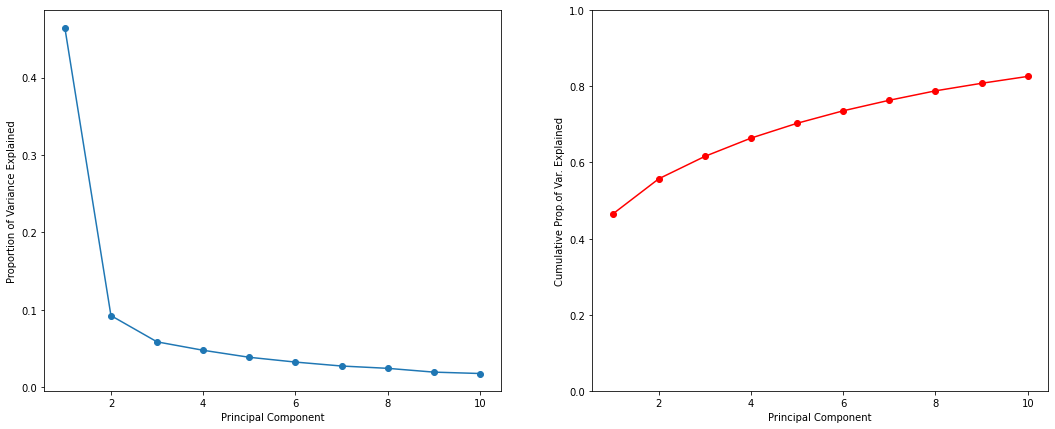

In [13]:
plt.subplot(1,2,1)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.plot(pr_var[:,0],pr_var[:,1],marker='o')

plt.subplot(1,2,2)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Prop.of Var. Explained")
plt.ylim(0, 1)

plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams["font.size"] = 15
plt.plot(pr_var[:,0],pr_var[:,2],marker='o', color='r')

So as we can see from the above figures, and especially from the scree plot on the left, is that the so called "elbow" appears on the second principal component. This is a good justification to support that the first 2 principal components are a good point to stop. We could potentially also include the 3rd one but this could be debateable as it doesn't provide a significant improvement in the proportion of variance explained, compared to the first 2.

So we are going to indeed stop at the first 2 principal components and use the transformed data coming out of it to run again our 2 classifiers.

In [14]:
low_dim_pca = PCA(n_components=2)
transformed_images = low_dim_pca.fit_transform(images)

#### Post-PCA - 2-Dimensional Data - 1-NN and Linear SVC
Run the 5-fold cross validation for the 2-dimensional data and report the scores per fold and their mean. Note that in the `cv` argument we provide the same cross validation iterator as the one we created for the high-dimensional case. This will enable us to make some fair comparisons.

In [15]:
scores_1nn_low = cross_val_score(one_nn,transformed_images,labels,cv=cv_shuf)
print("Scores for each of the 5 folds: {0}".format(scores_1nn_low))
print("Mean: {0:.3f}".format(np.array(scores_1nn_low).mean()))

Scores for each of the 5 folds: [0.66666667 0.83333333 0.5        0.66666667 0.83333333]
Mean: 0.700


In [16]:
scores_lin_svc_low = cross_val_score(linear_svc,transformed_images,labels,cv=cv_shuf)
print("Scores for each of the 5 folds: {0}".format(scores_lin_svc_low))
print("Mean: {0:.3f}".format(np.array(scores_lin_svc_low).mean()))

Scores for each of the 5 folds: [0.66666667 0.83333333 0.         0.5        0.66666667]
Mean: 0.533


/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblin

### Conclusions on the classifiers and the PCA application
Let's summarise the data in a table.

| Classifier | Input Dimensions | Accuracy Mean of 5 folds | Notes |
|:--:|:--:|:--:|:--:|
| **1-NN** |$(30,30000)$|**80.0%**|Before PCA applied<br/>Best accuracy among all cases<br/>Input data with colour information|
| **Linear SVC** |$(30,30000)$|_76.7%_|Before PCA applied<br/>Input data with colour information|
| **1-NN** |$(30,2)$|_70.0%_|After PCA applied<br/>Using 2 principal components<br/>Input data with colour information<br/>Best accuracy after dimensionality reduction|
| **Linear SVC** |$(30,2)$|_60.0%_|After PCA applied<br/>Using 2 principal components<br/>Input data with colour information|

So it's evident that the classifiers using the high-dimensional inputs are performing better, resulting in better accuracy compared to their counterparts that are based on the 2-dimensional outputs of PCA. This is not surprising at all.

From the dimensionality comparison perspective, this result is expected because the principal components are a low-dimensional representation; normalized linear combinations of the features of the initial data. They attempt to capture as much of the information as possible, but there is a limit to how much they can capture. So, the dimensionality reduction doesn't come free. It comes with the cost of explaining only a portion of the variability in the data. Thus, it is normal that the low-dimensional inputs are producing worse results in terms of accuracy. But in real-life cases, it is almost never a single-sided problem of maximizing accuracy. In the real world, high dimensionality comes with significant challenges, like storing the data and computation times and, thus, finding the balance of the dimensionality/accuracy trade-off is the key to the optimal solution.

From the perspective of comparing the classifiers, we see that the 1-NN classifier is performing better that the linear SVC. As it became evident when we plotted the images in the 2-dimensional space, those belonging to the same season tend to appear closer than the ones of the rest of the seasons with only a few exceptions for the Spring and Fall seasons in particular. As we saw, there are a few exceptions of Spring images appearing well inside the area of the Fall cluster and the other way around. For Linear SVC, these cases belong to the support vectors and they have a significant impact on the separating line that is produced. On the other hand, the 1-NN is impacted less from those outliers because even if they appear inside an area dominated by a cluster with images of a different season, they are still less likely to affect the rest of the cluster images, as there are probably other images in the cluster that are closer neighbors to the rest.

## 2 - Regularized Non-Negative Matrix Factorization

We want to solve the following minimization problem:
\begin{equation}
\underset{W,C}{\text{min}} \left\|{\textbf{X}-\textbf{WC}}\right\|_F^2 + \lambda\|\textbf{W}\|_F^2 + \lambda\|\textbf{C}\|_F^2
\label{eq:initial minimization problem} \tag{11}
\end{equation}

We know that:
\begin{equation}
\|A\|^2=Tr(A^TA)
\label{eq:square norm} \tag{12}
\end{equation}

So because of $\eqref{eq:square norm}$, the initial problem $\eqref{eq:initial minimization problem}$ becomes:
\begin{equation}
Tr((X-WC)^T(X-WC))+\lambda Tr(W^{T}W)+\lambda Tr(C^{T}C)
\end{equation}

\begin{equation}
= Tr((X^{T}-C^{T}W^{T})(X-WC))+ \lambda Tr(W^{T}W) +\lambda Tr(C^{T}C)
\end{equation}

\begin{equation}
= Tr(X^{T}X-X^{T}WC-C^{T}W^{T}X+C^{T}W^{T}WC) +\lambda Tr(W^{T}W) +\lambda Tr(C^{T}C)
\label{eq:prob step 1} \tag{13}
\end{equation}

And we are going to use the following property of trace:
\begin{equation}
Tr(A+B) = Tr(A) + Tr(B)
\label{eq:trace property 1} \tag{14}
\end{equation}

Now because of $\eqref{eq:trace property 1}$, equation $\eqref{eq:prob step 1}$ becomes:
\begin{equation}
Tr(X^{T}X)-Tr(X^{T}WC)-Tr(C^{T}W^{T}X)+Tr(C^{T}W^{T}WC) +\lambda Tr(W^{T}W) +\lambda Tr(C^{T}C)
\label{eq:prob step 2} \tag{15}
\end{equation}

### Computing the partial derivatives
We will now have to compute the derivatives of $\eqref{eq:prob step 2}$ with respect to $W$ and with respect to $C$.

The following properties are used:
* $Tr(ABCD) = Tr(BCDA) = Tr(CDAB) = Tr(DABC)$, ie. trace is invariant under cyclic permutations
* $\nabla_XTr(AX)=A^T$
* $\nabla_XTr(X^TA)=A$
* $\nabla_XTr(XAX^T)=X(A+A^T)$
* $\nabla_XTr(X^TAX)=AX+A^TX$
* $\nabla_XTr(AXB)=A^TB^T$
* $\nabla_XTr(AX^TB)=BA$
* $\nabla_XTr(X^{T}X)=2X$

#### Derivative with respect to $W$
Compute the derivatives of each term of equation $\eqref{eq:prob step 2}$ with respect to $W$:
1. $\nabla_WTr(X^{T}X)=0$
2. $\nabla_WTr(X^{T}WC) = \nabla_WTr(CX^{T}W) = (CX^{T})^{T} = XC^{T}$
3. $\nabla_WTr(C^{T}W^{T}X) = XC^{T} $
4. $\nabla_WTr(C^{T}W^{T}WC) = \nabla_WTr(WCC^{T}W^{T})= W((CC^{T})^{T}+CC^{T}) = 2WCC^{T}$
5. $\nabla_W \lambda Tr(W^{T}W)= 2\lambda W$
6. $\nabla_W \lambda Tr(C^{T}C) = 0$

Based on the above, $\eqref{eq:prob step 2}$ now becomes:
\begin{equation}
-XC^{T}-XC^{T}+2WCC^{T}+2\lambda W \\
= 2(-XC^{T}+WCC^{T}+\lambda W)
\end{equation}
The constant 2 can be ignored as it will be adjusted through the learning rate, thus we have:
\begin{equation}
\nabla_W\ell(W,C) = -XC^{T}+WCC^{T}+\lambda W
\label{eq:partial wrt W} \tag{16}
\end{equation}

#### Derivative with respect to $C$
Similar to what we did previously, we now compute the derivatives of each term of equation $\eqref{eq:prob step 2}$ with respect to $C$:
1. $\nabla_CTr(X^{T}X)=0$
2. $\nabla_CTr(X^{T}WC) = (X^{T}W)^T = W^{T}X$
3. $\nabla_CTr(C^{T}W^{T}X) = W^{T}X$
4. $\nabla_CTr(C^{T}W^{T}WC) = W^TWC+(W^TW)^TC=W^TWC+WW^TC=2W^TWC$
5. $\nabla_C \lambda Tr(W^{T}W)= 0$
6. $\nabla_C \lambda Tr(C^{T}C) = 2\lambda C$

Based on the above, $\eqref{eq:prob step 2}$ now becomes:
\begin{equation}
-W^{T}X-W^{T}X+2W^{T}WC+2\lambda C
= 2(-W^{T}X+W^{T}WC+\lambda C)
\end{equation}
and thus, with the constant 2 being ignored again as it'll be adjusted through the learning rate, we get:
\begin{equation}
\nabla_C\ell(W,C) = -W^{T}X+W^{T}WC+\lambda C
\label{eq:partial wrt C} \tag{17}
\end{equation}

#### Gradient Descent Steps
So using the derivatives we got ($\eqref{eq:partial wrt W}$ and $\eqref{eq:partial wrt C}$), we have the following gradient descent steps:

\begin{equation}
\textbf{C}_{t+1} = \textbf{C}_t - n_C \nabla_{C_t}\ell(W,C_t) \\
\textbf{W}_{t+1} = \textbf{W}_t - n_W \nabla_{W_t}\ell(W_t,C) \\
t = t + 1
\label{eq:gradient descent steps} \tag{18}
\end{equation}

Based on Lee and Saung in "*Algorithms for Non-Negative Matrix Factorization*", we are going to determine the length of the steps to be as follows:
* For $\textbf C$, we will use:
\begin{equation}
n_C = \frac{\textbf C}{\nabla_C\ell(W,C)} = \frac{\textbf C}{\mathbf{W^TWC}}
\label{eq:step size C} \tag{19}
\end{equation}
* For $\textbf W$, we will use:
\begin{equation}
n_W = \frac{\textbf W}{\nabla_W\ell(W,C)} = \frac{\textbf W}{\mathbf{WCC^T}}
\label{eq:step size W} \tag{20}
\end{equation}

And we will finally substitute the equations $\eqref{eq:gradient descent steps}$, $\eqref{eq:step size C}$ and $\eqref{eq:step size W}$ into $\eqref{eq:partial wrt W}$ and $\eqref{eq:partial wrt C}$ to get the update steps as follows:

\begin{equation}
W^{(t)}= W^{(t-1)} \frac{XC^T-\lambda W^{(t-1)}}{W^{(t-1)}CC^T}
\label{eq:update rule W} \tag{21}
\end{equation}

\begin{equation}
C^{(t)}= C^{(t-1)} \frac{W^TX-\lambda C^{(t-1)}}{W^TWC^{(t-1)}}
\label{eq:update rule C} \tag{22}
\end{equation}

#### Convergence Check
In order to determine whether the algorithm converges we will perform the following check after each iteration:
\begin{equation}
\frac{(\|X-W^{(t)}C^{(t)}\|_F^2 + \lambda \|W^{(t)}\|_F^2 + \lambda \|C^{(t)}\|_F^2)-(\|X-W^{(t-1)}C^{(t-1)}\|_F^2 + \lambda \|W^{(t-1)}\|_F^2 + \lambda \|C^{(t-1)}\|_F^2)}{\|X\|_F^2} < \epsilon
\label{eq:convergence check} \tag{23}
\end{equation}

If we find that the above check is satisfied, we will exit the loop and return the results. Otherwise, the algorithm will continue until it reaches the maximum number of iterations. The default value for max iterations will be 500 which can be easily configured.

#### Code Implementation
We will base the implementation of the Regularized NMF that was described, on the implementation for the Regular NMF that shared with us as part of the 6th Lab of the course. And this is what the code looks like after the necessary changes are applied:

In [17]:
def compute_error(X,l,W,C):
    return nla.norm(X-np.dot(W,C)) + l*nla.norm(W) + l*nla.norm(C)


def update_c(X,W,C,l):
    numerator = np.dot(W.T,X) - l*C
    denominator = np.dot(np.dot(W.T,W),C)
    C *= numerator
    C /= denominator
    return C


def update_w(X,W,C,l):
    numerator = np.dot(X,C.T) - l*W
    denominator = np.dot(W,(np.dot(C,C.T)))
    W *= numerator
    W /= denominator
    return W


def RegNMF(X,k,l,epsilon,max_iter=500):
    X_dim, samples = X.shape
    W = np.random.rand(X_dim, k)
    C = np.random.rand(k, samples)
    X_frob = nla.norm(X)
    errors = np.zeros(max_iter)
    converged = False
    for i in range(max_iter):
        #if (i+1)%50 == 0:
        #    print("Iteration {0}...".format(i+1))
        wNew=update_w(X,W,C,l)
        cNew=update_c(X,W,C,l)
        # pdb.set_trace()
        errors[i] = compute_error(X,l,wNew,cNew)/X_frob
        # Check for convergence according to the epsilon value
        if i>0 and np.abs(errors[i]-errors[i-1]) < epsilon:
            print("Converged for after {0} iterations. Error: {1}".format(i+1,errors[i]))
            converged = True
            break
        C = cNew
        W = wNew
    if i == max_iter-1 and not converged:
        print("No convergence after {0} iterations. Error: {1}".format(max_iter,errors[i]))
    return wNew, cNew, errors[i], i+1


#### Input Values for the exercise
The exercise instructs us to run the Regularized NMF implementation with the following input values:
* A randomly generated matrix $\textbf X$ of shape `(500,1000)` with non-negative values
* For $k$: `k = [1, 10, 100]`
* For $\epsilon$: `e = [0.01, 0.001, 0.0001]`
* There is no indication for the $\lambda$ value, but we will also experiment with a few of them ranging from 0.001 to 10: `l = [0.001, 0.01, 0.1, 1, 10]`


#### Executing for the above

Some info for the execution:
* We are randomly initialising the X array outside of the loops so that the results are comparable.
* If we want to make sure that everyone who runs this will get the same results, we could also introduce a random seed but there is no real point to do this now.

In [18]:
# Setting max iterations to something quite high for now
max_iter = 500

# Randomly initializing the X matrix here so that it's the same for all iterations
X = np.random.rand(500,1000)
k_list = [1, 10, 100]
epsilon_list = [0.01, 0.001, 0.0001]
l_list = [0.001, 0.01, 0.1, 1, 10]
errors_info = np.zeros((len(k_list)*len(epsilon_list)*len(l_list),5))
i = 0
for k in k_list:
    for epsilon in epsilon_list:
        for l in l_list:
            print("Running for k: {0}, epsilon: {1}, lambda: {2} ...".format(k, epsilon, l))
            W, C, error, iterations = RegNMF(X, k, l, epsilon, max_iter)
            if np.isnan(error):
                error = sys.maxsize
            errors_info[i] = [error, k, l, epsilon, iterations]
            i += 1

Running for k: 1, epsilon: 0.01, lambda: 0.001 ...
Converged for after 2 iterations. Error: 0.4992748926289199
Running for k: 1, epsilon: 0.01, lambda: 0.01 ...
Converged for after 2 iterations. Error: 0.5001096697130739
Running for k: 1, epsilon: 0.01, lambda: 0.1 ...
Converged for after 2 iterations. Error: 0.5084498802520059
Running for k: 1, epsilon: 0.01, lambda: 1 ...
Converged for after 2 iterations. Error: 0.591716179271106
Running for k: 1, epsilon: 0.01, lambda: 10 ...
Converged for after 2 iterations. Error: 1.4117489956019493
Running for k: 1, epsilon: 0.001, lambda: 0.001 ...
Converged for after 2 iterations. Error: 0.4992748239995463
Running for k: 1, epsilon: 0.001, lambda: 0.01 ...
Converged for after 2 iterations. Error: 0.5001095501134682
Running for k: 1, epsilon: 0.001, lambda: 0.1 ...
Converged for after 2 iterations. Error: 0.5084432517973849
Running for k: 1, epsilon: 0.001, lambda: 1 ...
Converged for after 2 iterations. Error: 0.591771518850368
Running for k: 1

/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/gchoumos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


No convergence after 500 iterations. Error: nan
Running for k: 100, epsilon: 0.001, lambda: 0.001 ...
Converged for after 2 iterations. Error: 0.4994495233716543
Running for k: 100, epsilon: 0.001, lambda: 0.01 ...
Converged for after 2 iterations. Error: 0.5035099424853017
Running for k: 100, epsilon: 0.001, lambda: 0.1 ...
Converged for after 12 iterations. Error: 0.529980020993192
Running for k: 100, epsilon: 0.001, lambda: 1 ...
Converged for after 35 iterations. Error: 0.6171310816350374
Running for k: 100, epsilon: 0.001, lambda: 10 ...
No convergence after 500 iterations. Error: nan
Running for k: 100, epsilon: 0.0001, lambda: 0.001 ...
Converged for after 157 iterations. Error: 0.42973735597774265
Running for k: 100, epsilon: 0.0001, lambda: 0.01 ...
Converged for after 164 iterations. Error: 0.43235204308845787
Running for k: 100, epsilon: 0.0001, lambda: 0.1 ...
Converged for after 183 iterations. Error: 0.4469342373396148
Running for k: 100, epsilon: 0.0001, lambda: 1 ...
Co

#### Results for combinations of given values for $k$ and $\epsilon$

What we notice from the above execution, is that
* The best error achieved is around 0.42
* In most cases we manage to reach convergence after only a few iterations.
* We tried some values for 𝜆 starting from very small ones, to quite big (for a regularization parameter). The value 10 for example led to the worst results by far.
* It looks like $\lambda$ contributes a lot to the number of iterations, and this is more evident for larger values of $k$.
* The stricter the regularization, the more propable it becomes that the iterations required for convergence will increase.
* The above is expected though, as the more strict we become with regularization (larger values for $\lambda$), the slower we are able to move towards the direction of the minimum.
* $k$ is also playing a role in the number of iterations
* The higher the value of $k$, the more likely it becomes that more iterations are needed for convergence. That is also expected as the increase in the number of features leads to increase in the dimensionality of the matrices we are looking for.
* $k$ is playing a big role in the error achieved as well.
* The above is another thing that doesn't come as a surprise. The more features the algorithm is allowed to use, the better it is able to reach to $W$ and $C$ matrices that reproduce the initial data closer.
* The combination of large values for $k$ along with large values for the regularization parameter $\lambda$, is one that gets very bad as we could see that we failed to converge for those cases.
* For the above cases of big $\lambda$ with big $k$, we also saw that we had cases that were reaching an overflow situation.

For any executions that resulted in overflows (it was only 3 of them), the corresponding score was set to the maximum integer value so that they are excluded from the calculations of the "best" run achieving the lowest error.

Which we'll do now. Let's get the execution with the lowest error along with its parameter values:

In [19]:
best = errors_info[np.argmin(errors_info[:, 0]), :]
print("Best execution with the lowest achieved error is the one with:")
print("k: {0}".format(int(best[1])))
print("regularisation parameter lamda: {0}".format(best[2]))
print("epsilon: {0}".format(best[3]))
print("Score achieved: {0:.6f}".format(best[0]))
print("Iterations for that run: {0}".format(int(best[4])))

Best execution with the lowest achieved error is the one with:
k: 100
regularisation parameter lamda: 0.001
epsilon: 0.0001
Score achieved: 0.429737
Iterations for that run: 157


So we got the best results for a large number of $k$ along with the "softest" regularization, combined with the smallest epsilon value from our list.

This is the result that would be expected beforehand, so no surprises here.

### Using the Regularized NMF implementation on an actual image

What would be nice to do now, is to also apply the implementation we did on an actual image and see how this works on an example where we can evaluate the results.

I am using an image of an owl that I found through Google. I searched for dimensions `500x1000` in particular so that I don't have to scale it and make it looking weird. Here is the URL where you can find it:
https://i.pinimg.com/564x/ee/fd/8b/eefd8b7fa3d2043127b73c56039936ee.jpg

Let's load it in grayscale and see how it looks like:

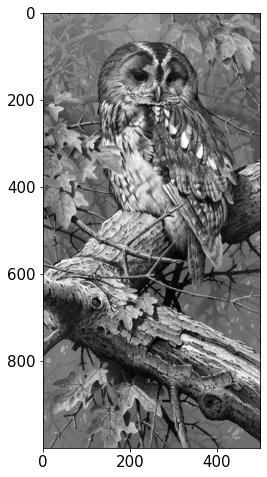

In [20]:
path = './owl'
file = 'owl_500x1000.jpg'
owl = cv2.imread('{0}/{1}'.format(path,file),0)
plt.figure(figsize=(8,8))
plt.imshow(owl,'gray')
plt.show()

And let's see what this image will look like if we:
* Pass it through the Regularized NMF we implemented
* Use the best values that achieved the lowest error for the random data we run earlier
  * k = 100
  * lambda = 0.001
  * epsilon = 0.0001

Converged for after 216 iterations. Error: 0.16389473395208226


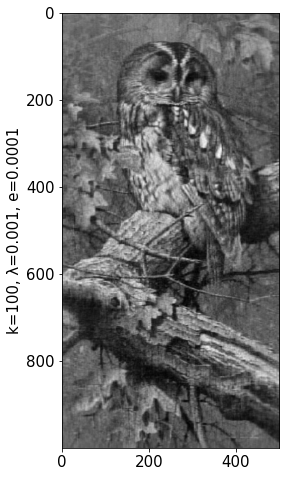

In [21]:
k=100
l=0.001
epsilon=0.0001
max_iter=1000
W, C, error, iterations = RegNMF(owl, k, l, epsilon, max_iter)
new_owl = np.dot(W,C)
plt.figure(figsize=(4, 8))
plt.rcParams["font.size"] = 15
plt.imshow(new_owl, 'gray')
plt.ylabel("k=100, λ=0.001, e=0.0001")
plt.show()

The above seems like an acceptable result and it will probably be the best we can achieve for the set of parameters we have chosen to test.

However let's see how this image looks like for various parameters while keeping the value of $k$ fixed. For this purpose we will use again some code taken from lab 6.

We will start from value of $k$ being 20, because for the smaller values of $k$ we don't manage to get a resulting image that is recognizable as something other than noise.

#### For $k$ = 20

Converged for after 2 iterations. Error: 0.40811186092029506
Converged for after 2 iterations. Error: 0.40815909082723645
Converged for after 2 iterations. Error: 0.4101381055663127
Converged for after 2 iterations. Error: 0.42915220717074454
Converged for after 2 iterations. Error: 0.4081984246684583
Converged for after 2 iterations. Error: 0.40805012089598425
Converged for after 2 iterations. Error: 0.4101458690978707
Converged for after 2 iterations. Error: 0.4291449042869098
Converged for after 134 iterations. Error: 0.2568277647775403
Converged for after 139 iterations. Error: 0.2575054196941133
Converged for after 151 iterations. Error: 0.2605821330087929
Converged for after 154 iterations. Error: 0.2811085303067419


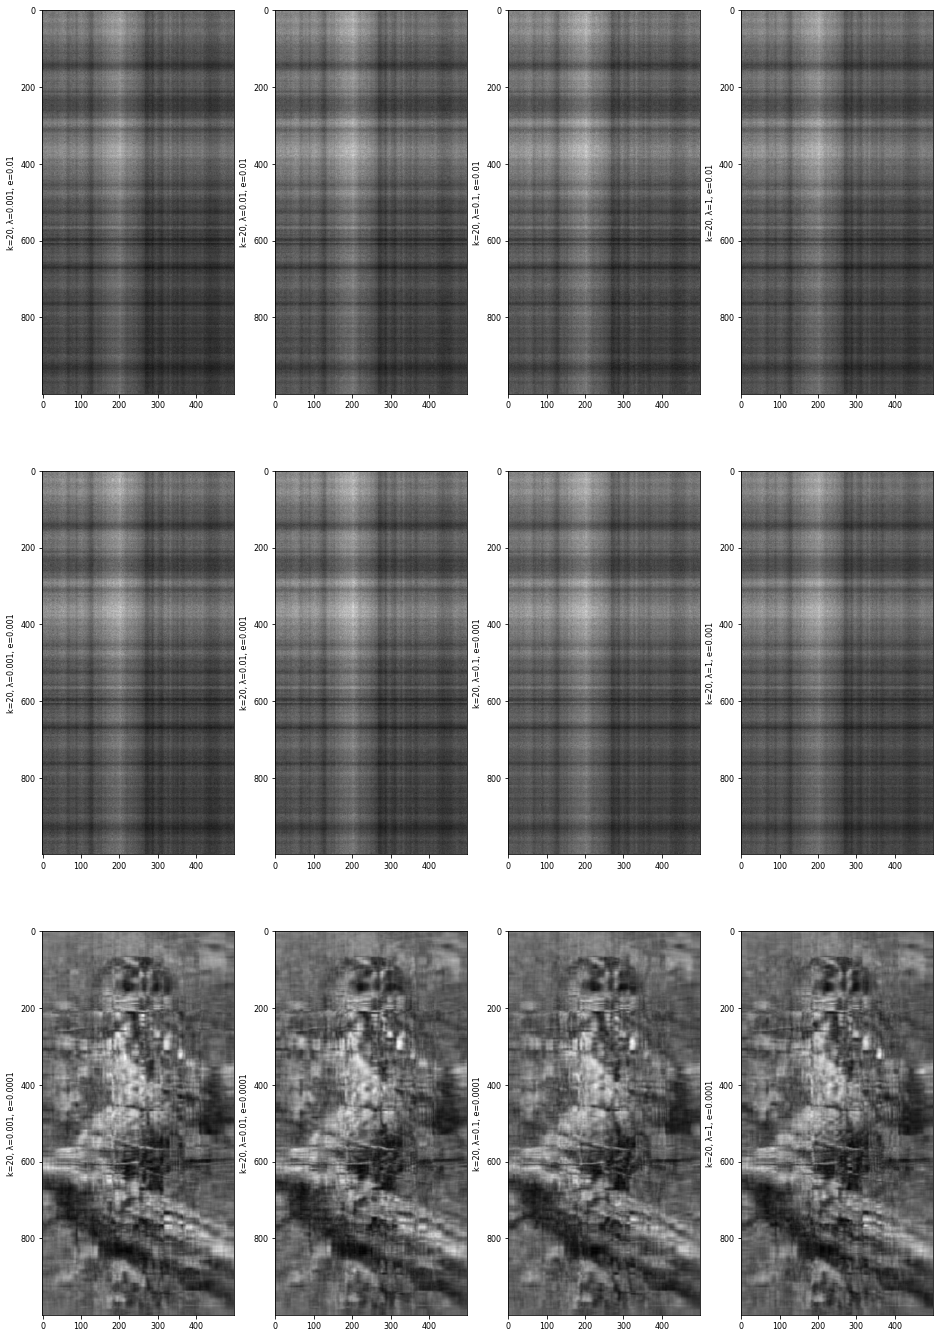

In [22]:
k = 20
max_iter = 1000
epsilon_list = [0.01, 0.001, 0.0001]
l_list = [0.001, 0.01, 0.1, 1]
plt.rcParams["font.size"] = 8
plt.figure(figsize=(16, 24))
i = 1
for epsilon in epsilon_list:
    for l in l_list:
        plt.subplot(3, 4, i)
        W, C, error, _ = RegNMF(owl, k, l, epsilon, max_iter)
        new_owl = np.dot(W,C)
        plt.ylabel("k={0}, λ={1}, e={2}".format(k,l,epsilon))
        plt.imshow(new_owl, 'gray')
        i += 1

From the above we undestand that after $k$, it is $\epsilon$ that is also really important with regards to the resulting image. The first 8 plots above are noise, while we only start seeing recognisable results in the last 4 plots where $\epsilon$ is as low as 0.0001.

Another thing that stands out is the behaviour of the resulting image according to $\lambda$. While $\lambda$ seemed to play an important role earlier with respect to the number of iterations required for convergence, it seems that it does not contribute much now to the resulting image! We can see that we get recognizable images for the lowest epsilon regardless of $\lambda$ which only led to some small changes in the error.

Let's do the same for $k$ set to 50.

#### For $k$ = 50

Converged for after 2 iterations. Error: 0.40495120138760143
Converged for after 2 iterations. Error: 0.4050300121216106
Converged for after 2 iterations. Error: 0.4063515212788361
Converged for after 2 iterations. Error: 0.41910088861076
Converged for after 2 iterations. Error: 0.40486800506680304
Converged for after 2 iterations. Error: 0.4051332342384203
Converged for after 2 iterations. Error: 0.4064725556369459
Converged for after 2 iterations. Error: 0.4191826277279396
Converged for after 184 iterations. Error: 0.20470193784112853
Converged for after 181 iterations. Error: 0.20368641699275053
Converged for after 182 iterations. Error: 0.20459460650743572
Converged for after 186 iterations. Error: 0.22442787704489212


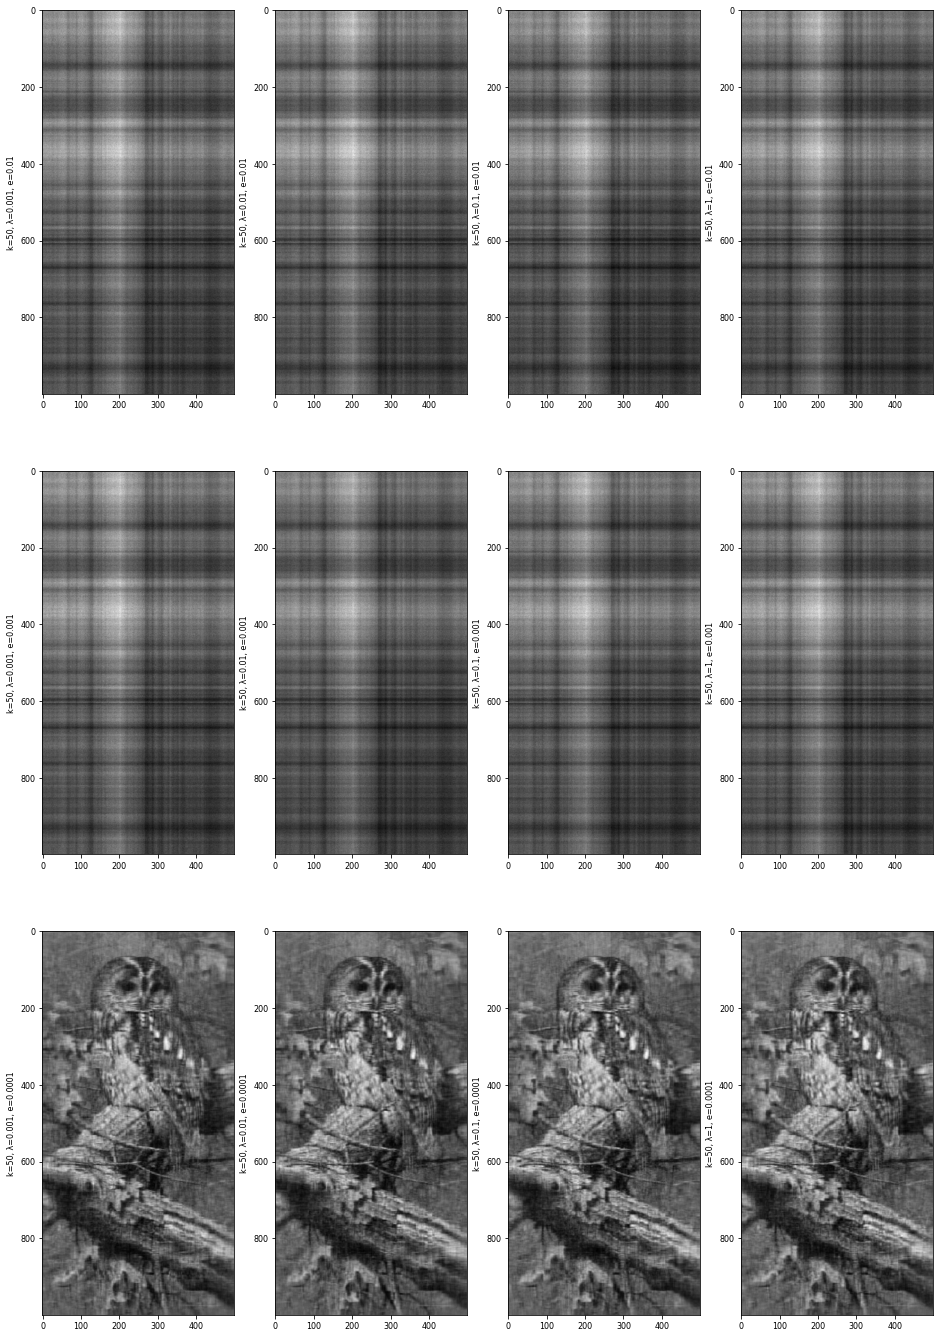

In [23]:
k = 50
max_iter = 1000
epsilon_list = [0.01, 0.001, 0.0001]
l_list = [0.001, 0.01, 0.1, 1]
plt.rcParams["font.size"] = 8
plt.figure(figsize=(16, 24))
i = 1
for epsilon in epsilon_list:
    for l in l_list:
        plt.subplot(3, 4, i)
        W, C, error, _ = RegNMF(owl, k, l, epsilon, max_iter)
        new_owl = np.dot(W,C)
        plt.ylabel("k={0}, λ={1}, e={2}".format(k,l,epsilon))
        plt.imshow(new_owl, 'gray')
        i += 1

No surprises again. We get good results only for the smallest value of $\epsilon$. But this time they look way better.

And let's do the same for $k$ set to 100.

#### For $k$ = 100

Converged for after 2 iterations. Error: 0.40384489911212396
Converged for after 2 iterations. Error: 0.40389506683915966
Converged for after 2 iterations. Error: 0.4049185953167198
Converged for after 2 iterations. Error: 0.4147974219353586
Converged for after 2 iterations. Error: 0.4038146111220491
Converged for after 2 iterations. Error: 0.40388392968979664
Converged for after 2 iterations. Error: 0.40486741042139013
Converged for after 2 iterations. Error: 0.41473767176722215
Converged for after 213 iterations. Error: 0.1630857849667344
Converged for after 213 iterations. Error: 0.1651171225412247
Converged for after 214 iterations. Error: 0.16625394296031523
Converged for after 215 iterations. Error: 0.18182895222958398


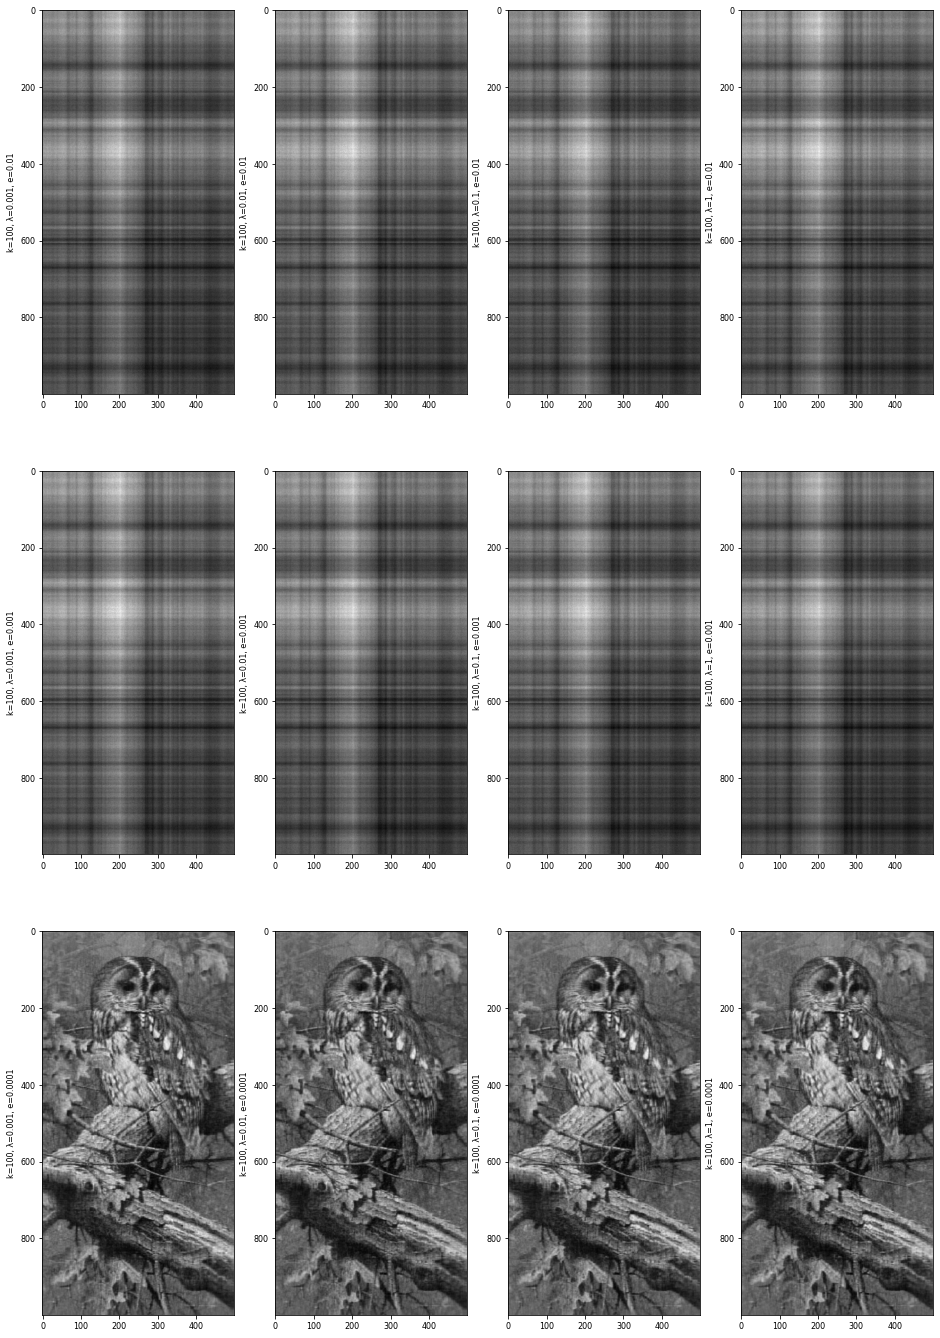

In [24]:
k = 100
max_iter = 1000
epsilon_list = [0.01, 0.001, 0.0001]
l_list = [0.001, 0.01, 0.1, 1]
plt.rcParams["font.size"] = 8
plt.figure(figsize=(16, 24))
i = 1
for epsilon in epsilon_list:
    for l in l_list:
        plt.subplot(3, 4, i)
        W, C, error, _ = RegNMF(owl, k, l, epsilon, max_iter)
        new_owl = np.dot(W,C)
        plt.ylabel("k={0}, λ={1}, e={2}".format(k,l,epsilon))
        plt.imshow(new_owl, 'gray')
        i += 1

### Thanks for checking this!
Thanks for your time reading through this Notebook! I will be happy to provide further information if needed!

Cheers,
George

## References
1. Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013). _An Introduction to Statistical Learning with Applications in R_. New York: Springer.
2. Jake VanderPlas (2017), _Python Data Science Handbook, Essentials tools for working with data_, O' Reilly
3. Article/Excerpt from the above book, _In Depth: Principal Component Analysis_, https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
4. OpenCV Tutotal: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html
5. Sci-kit learn documention on PCA, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
6. Article/Tutorial from user "daidalos" posted on January 27, 2019 on moonbooks.org, _How to insert an image (a picture of a photo) in a matplotlib figure_. https://moonbooks.org/Articles/How-to-insert-an-image-a-picture-or-a-photo-in-a-matplotlib-figure/
7. Wikipedia Contributors, "Principal component analysis", Wikipedia, The Free Encyclopedia, 2020 (access date: August 24, 2020), https://en.wikipedia.org/wiki/Principal_component_analysis
8. Wikipedia Contributors, "Curse of dimensionality", Wikipedia, The Free Encyclopedia, 2020 (access date: August 24, 2020), https://en.wikipedia.org/wiki/Curse_of_dimensionality
9. Wikipedia Contributors, "Albedo", Wikipedia, The Free Encyclopedia, 2020 (access date: August 24, 2020), https://en.wikipedia.org/wiki/Albedo
10. Wikipedia Contributors, "Trace (linear algebra)", Wikipedia, The Free Encyclopedia, 2020 (access date: August 23, 2020), https://en.wikipedia.org/wiki/Trace_(linear_algebra)
11. _Multi and Megavariate Data Analysis: Part 1, PCA_ , https://umetrics.com/sites/default/files/books/sample_chapters/multimega_parti-3_0.pdf
12. Pedro Domingos, _A Few Useful Things to Know About Machine Learning_ , doi:10.1145/2347736.2347755 - (https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
13. _Seasonal Changes in Earth's Surface Albedo_ , Nasa Earth Observatory, https://earthobservatory.nasa.gov/images/5471/seasonal-changes-in-earths-surface-albedo
14. John DeRiggi, _Remote Sensing Part III: Identify Healthy Vegetation From Space_ , Jan 23, 2017 - https://dai-global-digital.com/lush-green-remote-sensing.html
15. Article on Altavian.com, _What is CIR Imagery and what is it used for?_ , Unknown Author, https://www.altavian.com/blog/2016/8/cir-imagery
16. Sci-kit learn documentation on Neighbors module, https://scikit-learn.org/stable/modules/neighbors.html
17. Sci-kit learn documentation on LinearSVC, https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
18. Sci-kit learn documentation on decomposition, https://scikit-learn.org/stable/modules/decomposition.html#nmf
19. Thread in stats.stackexchange.com, _Deriving Multiplicative Update Rules for NMF_ , https://stats.stackexchange.com/questions/351359/deriving-multiplicative-update-rules-for-nmf
20. Daniel D. Lee, H. Sebastian Seung - _Algorithms for Non-Negative Matrix Factorization_ - https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
21. Nicolas Gillis, _The Why and How of Non-Negative Matrix Factorization_ - https://arxiv.org/pdf/1401.5226.pdf
22. Kaare Brandt Petersen, Michael Syskind Pedersen, _The Matrix Cookbook_ - http://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
22. V. Paul Pauca, J. Piper, Robert J. Plemmons, _Nonnegative matrix factorization for spectral data analysis_
23. Patrik O. Hoyer, _Non-Negative Sparse Coding_
